## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp "/content/gdrive/MyDrive/xview_recognition.zip" "/content/"

In [ ]:
!unzip "/content/xview_recognition.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: xview_train/Shipping container/778dd2fe-ad63-4889-9380-8a7acba75977.tif  
  inflating: xview_train/Shipping container/7535dd1d-92f1-4007-8264-a6750c99a899.tif  
  inflating: xview_train/Shipping container/199e85aa-99c7-470b-9066-073634f2e02c.tif  
  inflating: xview_train/Shipping container/a4d2949f-f9f3-4fd3-ace0-4af8400bfd4a.tif  
  inflating: xview_train/Shipping container/44430654-4ec0-4f66-b6fa-86448807b011.tif  
  inflating: xview_train/Shipping container/ce8e443f-b915-486e-af5c-13e5f2ebb9f1.tif  
  inflating: xview_train/Shipping container/1ae7c2a0-63ee-46d4-acaa-b86d3af581b8.tif  
  inflating: xview_train/Shipping container/6efd49ec-7789-483c-93d5-90fe2d5098b0.tif  
  inflating: xview_train/Shipping container/cf285f00-3242-4259-895b-2da7282c0aaa.tif  
  inflating: xview_train/Shipping container/6d96f2ec-ed73-4639-abe7-53485b52db05.tif  
  inflating: xview_train/Shipping container/c7fc8511-d3a7-4ae9-bc6d-4d5ce506cb9c

In [ ]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [ ]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [ ]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 29.4 MB/s eta 0:00:00


In [ ]:
import warnings
import rasterio
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, data_augmentation=False, do_shuffle=False):
    if data_augmentation:
        # Define data augmentation parameters
        data_gen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest',
        )

    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i + batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                img = load_geoimage(filename)
                # Apply data augmentation if enabled
                if data_augmentation:
                    img = data_gen.random_transform(img)
                images.append(img)
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            if images:
                images = np.array(images).astype(np.float32)
                labels = np.array(labels).astype(np.float32)
                yield images, labels
            else:
                # If there are no more images, break the loop
                break




In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [ ]:
import json

# Load database
json_file = 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [ ]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TerminateOnNaN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # Add BatchNormalization layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # Add BatchNormalization layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # Add BatchNormalization layer
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # Add BatchNormalization layer
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                        

In [ ]:
# Compile the model with a lower learning rate
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [ ]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 32
train_generator = generator_images(objs_train, batch_size, data_augmentation=True, do_shuffle=True)
validation_generator = generator_images(objs_valid, batch_size, data_augmentation=False, do_shuffle=False)

In [ ]:
import math
import numpy as np
print('Training model')
epochs = 30
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=validation_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/30
602/602 [==============================] - ETA: 0s - loss: 2.8196 - accuracy: 0.2848
Epoch 1: val_accuracy improved from -inf to 0.42891, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 331s 550ms/step - loss: 2.8196 - accuracy: 0.2848 - val_loss: 1.8409 - val_accuracy: 0.4289 - lr: 1.0000e-04
Epoch 2/30
602/602 [==============================] - ETA: 0s - loss: 2.1846 - accuracy: 0.3249
Epoch 2: val_accuracy improved from 0.42891 to 0.44855, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 320s 532ms/step - loss: 2.1846 - accuracy: 0.3249 - val_loss: 1.7416 - val_accuracy: 0.4486 - lr: 1.0000e-04
Epoch 3/30
602/602 [==============================] - ETA: 0s - loss: 1.9152 - accuracy: 0.3714
Epoch 3: val_accuracy improved from 0.44855 to 0.48550, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 317s 528ms/step - loss: 1.9152 - accuracy: 0.3714 - val_loss: 1.6469 - val_accuracy: 0.4855 - lr: 1.0000e-04
Epoch 4/30
602/602 [==============================] - ETA: 0s - loss: 1.8037 - accuracy: 0.4010
Epoch 4: val_accuracy did not improve from 0.48550
602/602 [==============================] - 309s 514ms/step - loss: 1.8037 - accuracy: 0.4010 - val_loss: 1.5371 - val_accuracy: 0.4790 - lr: 1.0000e-04
Epoch 5/30
602/602 [==============================] - ETA: 0s - loss: 1.7056 - accuracy: 0.4196
Epoch 5: val_accuracy improved from 0.48550 to 0.50702, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 318s 529ms/step - loss: 1.7056 - accuracy: 0.4196 - val_loss: 1.4185 - val_accuracy: 0.5070 - lr: 1.0000e-04
Epoch 6/30
602/602 [==============================] - ETA: 0s - loss: 1.6529 - accuracy: 0.4376
Epoch 6: val_accuracy improved from 0.50702 to 0.53461, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 319s 530ms/step - loss: 1.6529 - accuracy: 0.4376 - val_loss: 1.4030 - val_accuracy: 0.5346 - lr: 1.0000e-04
Epoch 7/30
602/602 [==============================] - ETA: 0s - loss: 1.6329 - accuracy: 0.4497
Epoch 7: val_accuracy improved from 0.53461 to 0.55753, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 316s 525ms/step - loss: 1.6329 - accuracy: 0.4497 - val_loss: 1.3133 - val_accuracy: 0.5575 - lr: 1.0000e-04
Epoch 8/30
602/602 [==============================] - ETA: 0s - loss: 1.5754 - accuracy: 0.4681
Epoch 8: val_accuracy improved from 0.55753 to 0.56595, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 320s 532ms/step - loss: 1.5754 - accuracy: 0.4681 - val_loss: 1.2856 - val_accuracy: 0.5659 - lr: 1.0000e-04
Epoch 9/30
602/602 [==============================] - ETA: 0s - loss: 1.5500 - accuracy: 0.4828
Epoch 9: val_accuracy did not improve from 0.56595
602/602 [==============================] - 309s 514ms/step - loss: 1.5500 - accuracy: 0.4828 - val_loss: 1.3171 - val_accuracy: 0.5426 - lr: 1.0000e-04
Epoch 10/30
602/602 [==============================] - ETA: 0s - loss: 1.5271 - accuracy: 0.4853
Epoch 10: val_accuracy improved from 0.56595 to 0.56782, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 319s 530ms/step - loss: 1.5271 - accuracy: 0.4853 - val_loss: 1.2891 - val_accuracy: 0.5678 - lr: 1.0000e-04
Epoch 11/30
602/602 [==============================] - ETA: 0s - loss: 1.5095 - accuracy: 0.4893
Epoch 11: val_accuracy did not improve from 0.56782
602/602 [==============================] - 316s 525ms/step - loss: 1.5095 - accuracy: 0.4893 - val_loss: 1.2871 - val_accuracy: 0.5664 - lr: 1.0000e-04
Epoch 12/30
602/602 [==============================] - ETA: 0s - loss: 1.4853 - accuracy: 0.4922
Epoch 12: val_accuracy improved from 0.56782 to 0.58934, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 314s 522ms/step - loss: 1.4853 - accuracy: 0.4922 - val_loss: 1.2272 - val_accuracy: 0.5893 - lr: 1.0000e-04
Epoch 13/30
602/602 [==============================] - ETA: 0s - loss: 1.4569 - accuracy: 0.5081
Epoch 13: val_accuracy improved from 0.58934 to 0.59963, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 314s 522ms/step - loss: 1.4569 - accuracy: 0.5081 - val_loss: 1.2088 - val_accuracy: 0.5996 - lr: 1.0000e-04
Epoch 14/30
602/602 [==============================] - ETA: 0s - loss: 1.4272 - accuracy: 0.5172
Epoch 14: val_accuracy improved from 0.59963 to 0.60711, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 309s 513ms/step - loss: 1.4272 - accuracy: 0.5172 - val_loss: 1.1871 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 15/30
602/602 [==============================] - ETA: 0s - loss: 1.4139 - accuracy: 0.5220
Epoch 15: val_accuracy did not improve from 0.60711
602/602 [==============================] - 306s 509ms/step - loss: 1.4139 - accuracy: 0.5220 - val_loss: 1.1791 - val_accuracy: 0.5921 - lr: 1.0000e-04
Epoch 16/30
602/602 [==============================] - ETA: 0s - loss: 1.4137 - accuracy: 0.5183
Epoch 16: val_accuracy improved from 0.60711 to 0.61693, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 314s 521ms/step - loss: 1.4137 - accuracy: 0.5183 - val_loss: 1.1339 - val_accuracy: 0.6169 - lr: 1.0000e-04
Epoch 17/30
602/602 [==============================] - ETA: 0s - loss: 1.3971 - accuracy: 0.5300
Epoch 17: val_accuracy did not improve from 0.61693
602/602 [==============================] - 307s 511ms/step - loss: 1.3971 - accuracy: 0.5300 - val_loss: 1.1611 - val_accuracy: 0.6024 - lr: 1.0000e-04
Epoch 18/30
602/602 [==============================] - ETA: 0s - loss: 1.3588 - accuracy: 0.5367
Epoch 18: val_accuracy did not improve from 0.61693
602/602 [==============================] - 306s 509ms/step - loss: 1.3588 - accuracy: 0.5367 - val_loss: 1.1313 - val_accuracy: 0.6043 - lr: 1.0000e-04
Epoch 19/30
602/602 [==============================] - ETA: 0s - loss: 1.3584 - accuracy: 0.5374
Epoch 19: val_accuracy improved from 0.61693 to 0.64406, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 315s 524ms/step - loss: 1.3584 - accuracy: 0.5374 - val_loss: 1.1067 - val_accuracy: 0.6441 - lr: 1.0000e-04
Epoch 20/30
602/602 [==============================] - ETA: 0s - loss: 1.3497 - accuracy: 0.5424
Epoch 20: val_accuracy did not improve from 0.64406
602/602 [==============================] - 305s 508ms/step - loss: 1.3497 - accuracy: 0.5424 - val_loss: 1.1628 - val_accuracy: 0.6006 - lr: 1.0000e-04
Epoch 21/30
602/602 [==============================] - ETA: 0s - loss: 1.3554 - accuracy: 0.5405
Epoch 21: val_accuracy did not improve from 0.64406
602/602 [==============================] - 306s 508ms/step - loss: 1.3554 - accuracy: 0.5405 - val_loss: 1.1470 - val_accuracy: 0.6183 - lr: 1.0000e-04
Epoch 22/30
602/602 [==============================] - ETA: 0s - loss: 1.2959 - accuracy: 0.5626
Epoch 22: val_accuracy did not improve from 0.64406
602/602 [==============================] - 306s 508ms/step - loss: 1.2959 - accuracy: 0.5626 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 317s 528ms/step - loss: 1.2547 - accuracy: 0.5731 - val_loss: 1.0008 - val_accuracy: 0.6614 - lr: 1.0000e-04
Epoch 28/30
602/602 [==============================] - ETA: 0s - loss: 1.2318 - accuracy: 0.5820
Epoch 28: val_accuracy improved from 0.66137 to 0.67259, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 324s 539ms/step - loss: 1.2318 - accuracy: 0.5820 - val_loss: 1.0294 - val_accuracy: 0.6726 - lr: 1.0000e-04
Epoch 29/30
602/602 [==============================] - ETA: 0s - loss: 1.2275 - accuracy: 0.5806
Epoch 29: val_accuracy did not improve from 0.67259
602/602 [==============================] - 313s 520ms/step - loss: 1.2275 - accuracy: 0.5806 - val_loss: 1.0749 - val_accuracy: 0.6427 - lr: 1.0000e-04
Epoch 30/30
602/602 [==============================] - ETA: 0s - loss: 1.2129 - accuracy: 0.5905
Epoch 30: val_accuracy improved from 0.67259 to 0.67493, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 319s 531ms/step - loss: 1.2129 - accuracy: 0.5905 - val_loss: 0.9685 - val_accuracy: 0.6749 - lr: 1.0000e-04
Best validation model: epoch 30  - val_accuracy 0.6749298572540283


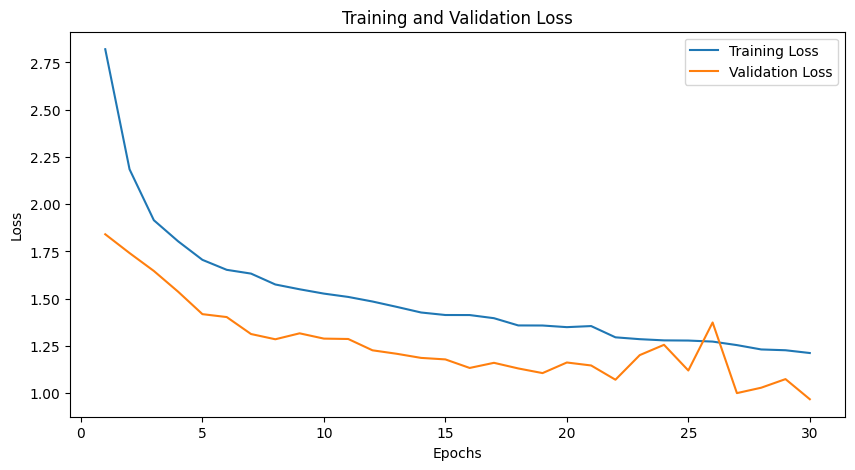

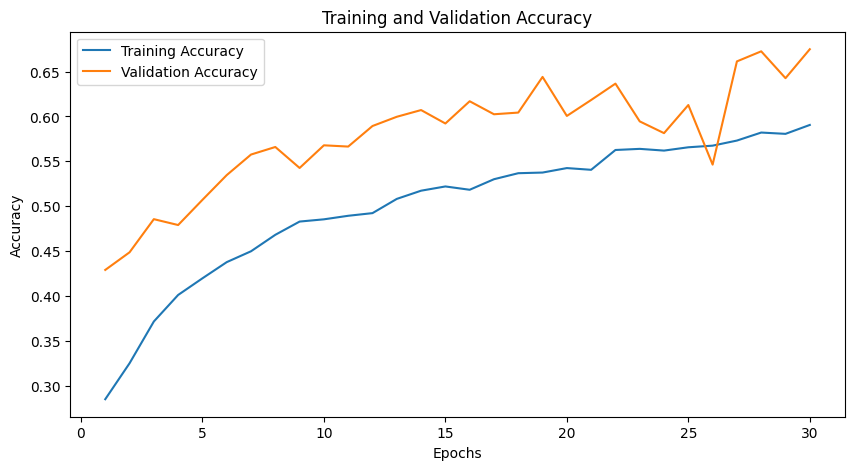

In [ ]:
# Plotting
epochs_range = range(1, epochs + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['loss'], label='Training Loss')
plt.plot(epochs_range, h.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [ ]:


import json

# Load database
json_file = 'xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [ ]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 [==============================] - 0s 17ms/step


<ipython-input-8-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


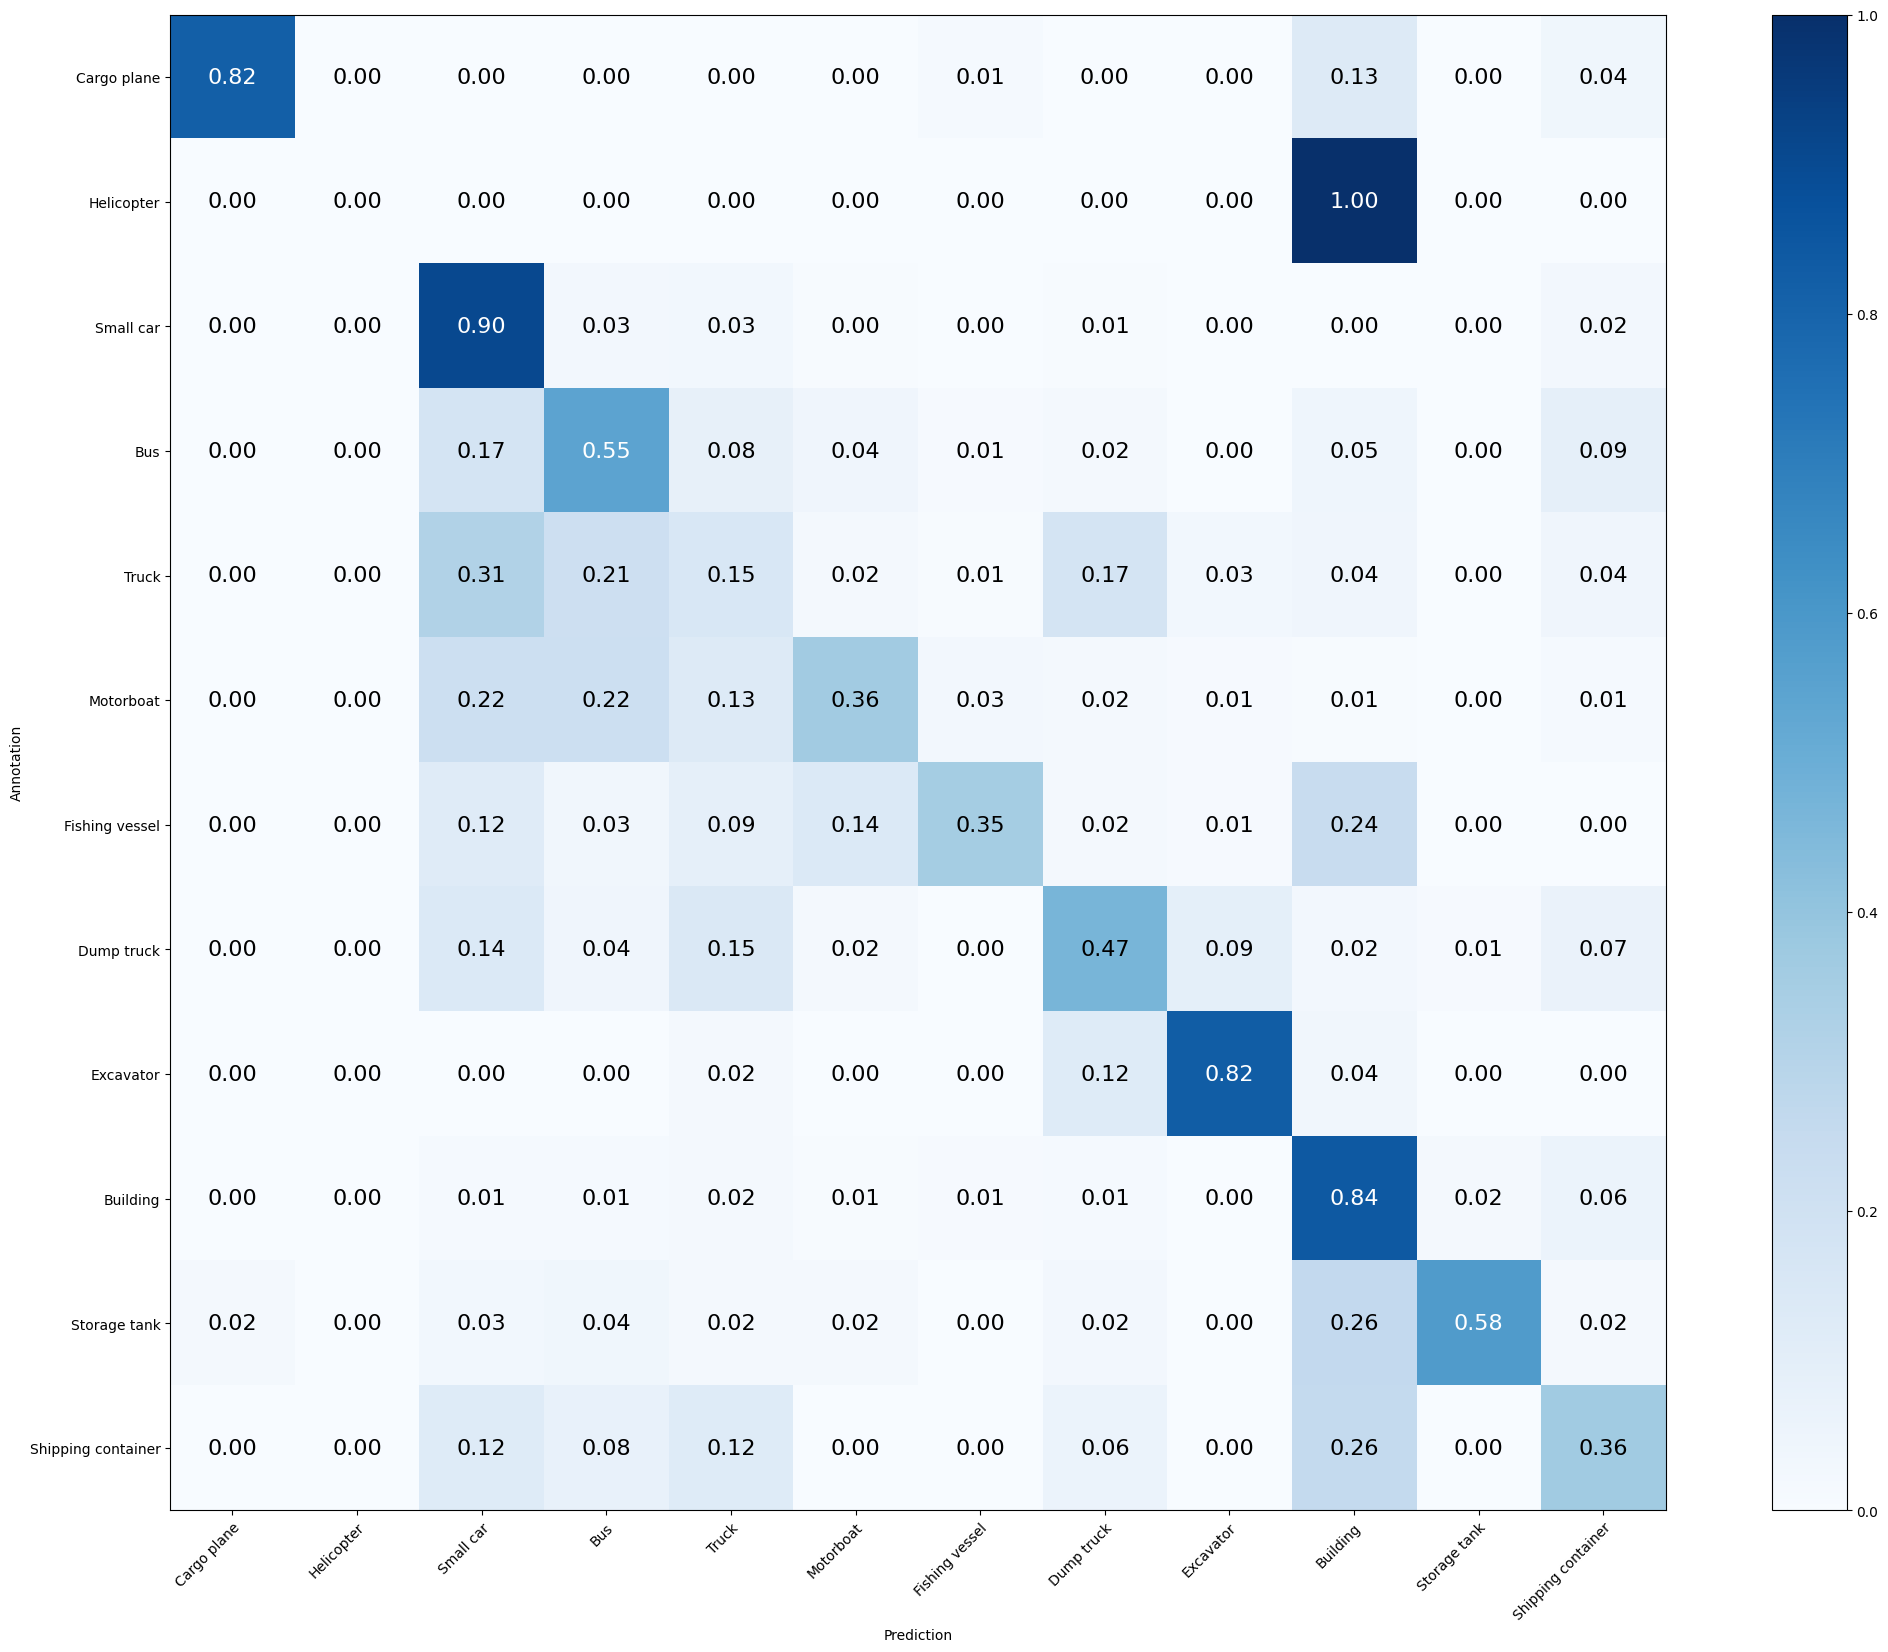

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 60.228%
Mean Recall: 51.788%
Mean Precision: 53.939%
> Cargo plane: Recall: 81.928% Precision: 91.892% Specificity: 99.765% Dice: 86.624%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 90.349% Precision: 61.711% Specificity: 87.291% Dice: 73.333%
> Bus: Recall: 54.545% Precision: 40.491% Specificity: 91.893% Dice: 46.479%
> Truck: Recall: 15.410% Precision: 26.111% Specificity: 94.292% Dice: 19.381%
> Motorboat: Recall: 36.041% Precision: 77.174% Specificity: 98.126% Dice: 49.135%
> Fishing vessel: Recall: 35.484% Precision: 62.264% Specificity: 99.213% Dice: 45.205%
> Dump truck: Recall: 46.721% Precision: 37.013% Specificity: 96.140% Dice: 41.304%
> Excavator: Recall: 82.456% Precision: 63.514% Specificity: 98.953% Dice: 71.756%
> Building: Recall: 84.133% Precision: 75.874% Specificity: 93.072% Dice: 79.790%
> Storage tank: Recall: 58.025% Precision: 91.558% Specificity: 99.457% Dice: 71.033%
> Shipping container

In [ ]:
!cp "/content/model.hdf5" "/content/gdrive/MyDrive/Nino/"
!cp "/content/xview_ann_test.json" "/content/gdrive/MyDrive/Nino/"
!cp "/content/xview_ann_train.json" "/content/gdrive/MyDrive/Nino/"

#### Report

You must prepare a report (PDF) describing:
* The problems and data sets (briefly).
* The process that you have followed to reach your solution for the “xview_recognition” benchmark, including your intermediate results. You must discuss and compare these results properly.
* Final network architectures, including optimization algorithms, regularization methods (dropout, data augmentation, etc.), number of layers/parameters, and performance obtained with your model on the train/valid/test data sets, including the plots of the evolution of losses and accuracy.
* It would also be very valuable your feedback on the use of “Cesvima” or “Google Colab" services.

In the submission via Moodle, attach your Python (.py) or Jupyter Notebook (.ipynb) source file, including in the report all results of computations attached to the code that generated them.

The assignment must be done in groups of 3 students.